In [2]:
# https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset
# https://www.cdc.gov/nchs/data/databriefs/db427-tables.pdf#4 - 5% 
# https://www.heartandstroke.ca/stroke/what-is-stroke
# https://www.healthline.com/health/stroke-vs-heart-attack

In [3]:
import pandas as pd
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline

# modeling imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, roc_curve
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
# 1 - If the person had a stroke
# 0 - If the person didnot have a stroke

df.stroke.value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [7]:
(249/(4861+249))*100

4.87279843444227

In [8]:
df.age.value_counts()

78.00    102
57.00     95
52.00     90
54.00     87
51.00     86
        ... 
0.48       3
1.40       3
0.16       3
0.08       2
0.40       2
Name: age, Length: 104, dtype: int64

(array([434., 362., 440., 484., 597., 583., 686., 559., 407., 558.]),
 array([8.0000e-02, 8.2720e+00, 1.6464e+01, 2.4656e+01, 3.2848e+01,
        4.1040e+01, 4.9232e+01, 5.7424e+01, 6.5616e+01, 7.3808e+01,
        8.2000e+01]),
 <BarContainer object of 10 artists>)

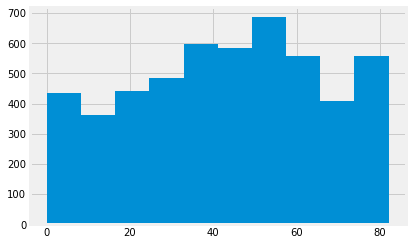

In [9]:
plt.hist(df.age)

In [10]:
df.age.describe()

count    5110.000000
mean       43.226614
std        22.612647
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64

In [11]:
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [12]:
df.ever_married.value_counts()

Yes    3353
No     1757
Name: ever_married, dtype: int64

In [13]:
df.work_type.value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [14]:
df.Residence_type.value_counts()

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

In [15]:
df.smoking_status.value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [15]:
df[df.isnull().any(axis=1)]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,61843,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5039,42007,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,28788,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,32235,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,7293,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


In [16]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [17]:
df.bmi.value_counts()

28.7    41
28.4    38
27.7    37
27.6    37
26.7    37
        ..
48.0     1
49.4     1
47.4     1
46.6     1
54.0     1
Name: bmi, Length: 418, dtype: int64

In [18]:
df.dropna(axis=0, inplace=True)

In [19]:
# drop the row with "other" in gender as it is only one row
df = df[df.gender != 'Other']
df.gender.value_counts()

Female    2897
Male      2011
Name: gender, dtype: int64

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4908 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4908 non-null   int64  
 1   gender             4908 non-null   object 
 2   age                4908 non-null   float64
 3   hypertension       4908 non-null   int64  
 4   heart_disease      4908 non-null   int64  
 5   ever_married       4908 non-null   object 
 6   work_type          4908 non-null   object 
 7   Residence_type     4908 non-null   object 
 8   avg_glucose_level  4908 non-null   float64
 9   bmi                4908 non-null   float64
 10  smoking_status     4908 non-null   object 
 11  stroke             4908 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 498.5+ KB


In [21]:
df.tail()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
5104,14180,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
5109,44679,Female,44.0,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


In [22]:
df.reset_index(drop=True, inplace=True)

In [23]:
df.tail()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
4903,14180,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0
4904,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
4905,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
4906,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
4907,44679,Female,44.0,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


In [24]:
df = pd.get_dummies(df, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], drop_first=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4908 entries, 0 to 4907
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              4908 non-null   int64  
 1   age                             4908 non-null   float64
 2   hypertension                    4908 non-null   int64  
 3   heart_disease                   4908 non-null   int64  
 4   avg_glucose_level               4908 non-null   float64
 5   bmi                             4908 non-null   float64
 6   stroke                          4908 non-null   int64  
 7   gender_Male                     4908 non-null   uint8  
 8   ever_married_Yes                4908 non-null   uint8  
 9   work_type_Never_worked          4908 non-null   uint8  
 10  work_type_Private               4908 non-null   uint8  
 11  work_type_Self-employed         4908 non-null   uint8  
 12  work_type_children              49

In [25]:
df.corr()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
id,1.000000,0.009124,0.001206,0.004058,0.006252,0.003238,0.004878,0.006474,0.017099,0.003880,0.026342,-0.021778,-0.019801,0.005167,0.008733,0.001794,0.013787
age,0.009124,1.000000,0.274395,0.257104,0.236000,0.333314,0.232313,-0.030280,0.680742,-0.079399,0.120169,0.327306,-0.635044,0.010795,0.242874,0.124273,0.076743
hypertension,0.001206,0.274395,1.000000,0.115978,0.180614,0.167770,0.142503,0.021811,0.162350,-0.021345,-0.004581,0.111770,-0.126590,-0.001140,0.062252,0.066671,0.028188
heart_disease,0.004058,0.257104,0.115978,1.000000,0.154577,0.041322,0.137929,0.082950,0.111203,-0.015315,-0.000239,0.081466,-0.088092,-0.002409,0.071477,-0.020722,0.048667
avg_glucose_level,0.006252,0.236000,0.180614,0.154577,1.000000,0.175672,0.138984,0.053161,0.151657,-0.013980,0.009124,0.069133,-0.101122,-0.007441,0.073907,0.032225,0.011055
bmi,0.003238,0.333314,0.167770,0.041322,0.175672,1.000000,0.042341,-0.026164,0.341553,-0.028615,0.208205,0.072634,-0.448779,-0.000293,0.107463,0.107847,0.088261
stroke,0.004878,0.232313,0.142503,0.137929,0.138984,0.042341,1.000000,0.006904,0.105051,-0.014152,0.014972,0.055338,-0.080990,0.005988,0.057443,0.010690,0.021513
gender_Male,0.006474,-0.030280,0.021811,0.082950,0.053161,-0.026164,0.006904,1.000000,-0.036380,0.012316,-0.038831,-0.022210,0.091732,-0.004351,0.039078,-0.093881,0.011623
ever_married_Yes,0.017099,0.680742,0.162350,0.111203,0.151657,0.341553,0.105051,-0.036380,1.000000,-0.092012,0.157102,0.191389,-0.545687,0.004707,0.176745,0.105062,0.106479
work_type_Never_worked,0.003880,-0.079399,-0.021345,-0.015315,-0.013980,-0.028615,-0.014152,0.012316,-0.092012,1.000000,-0.077658,-0.029057,-0.026703,0.023419,-0.030404,0.035857,-0.028206


/Users/bsameera/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


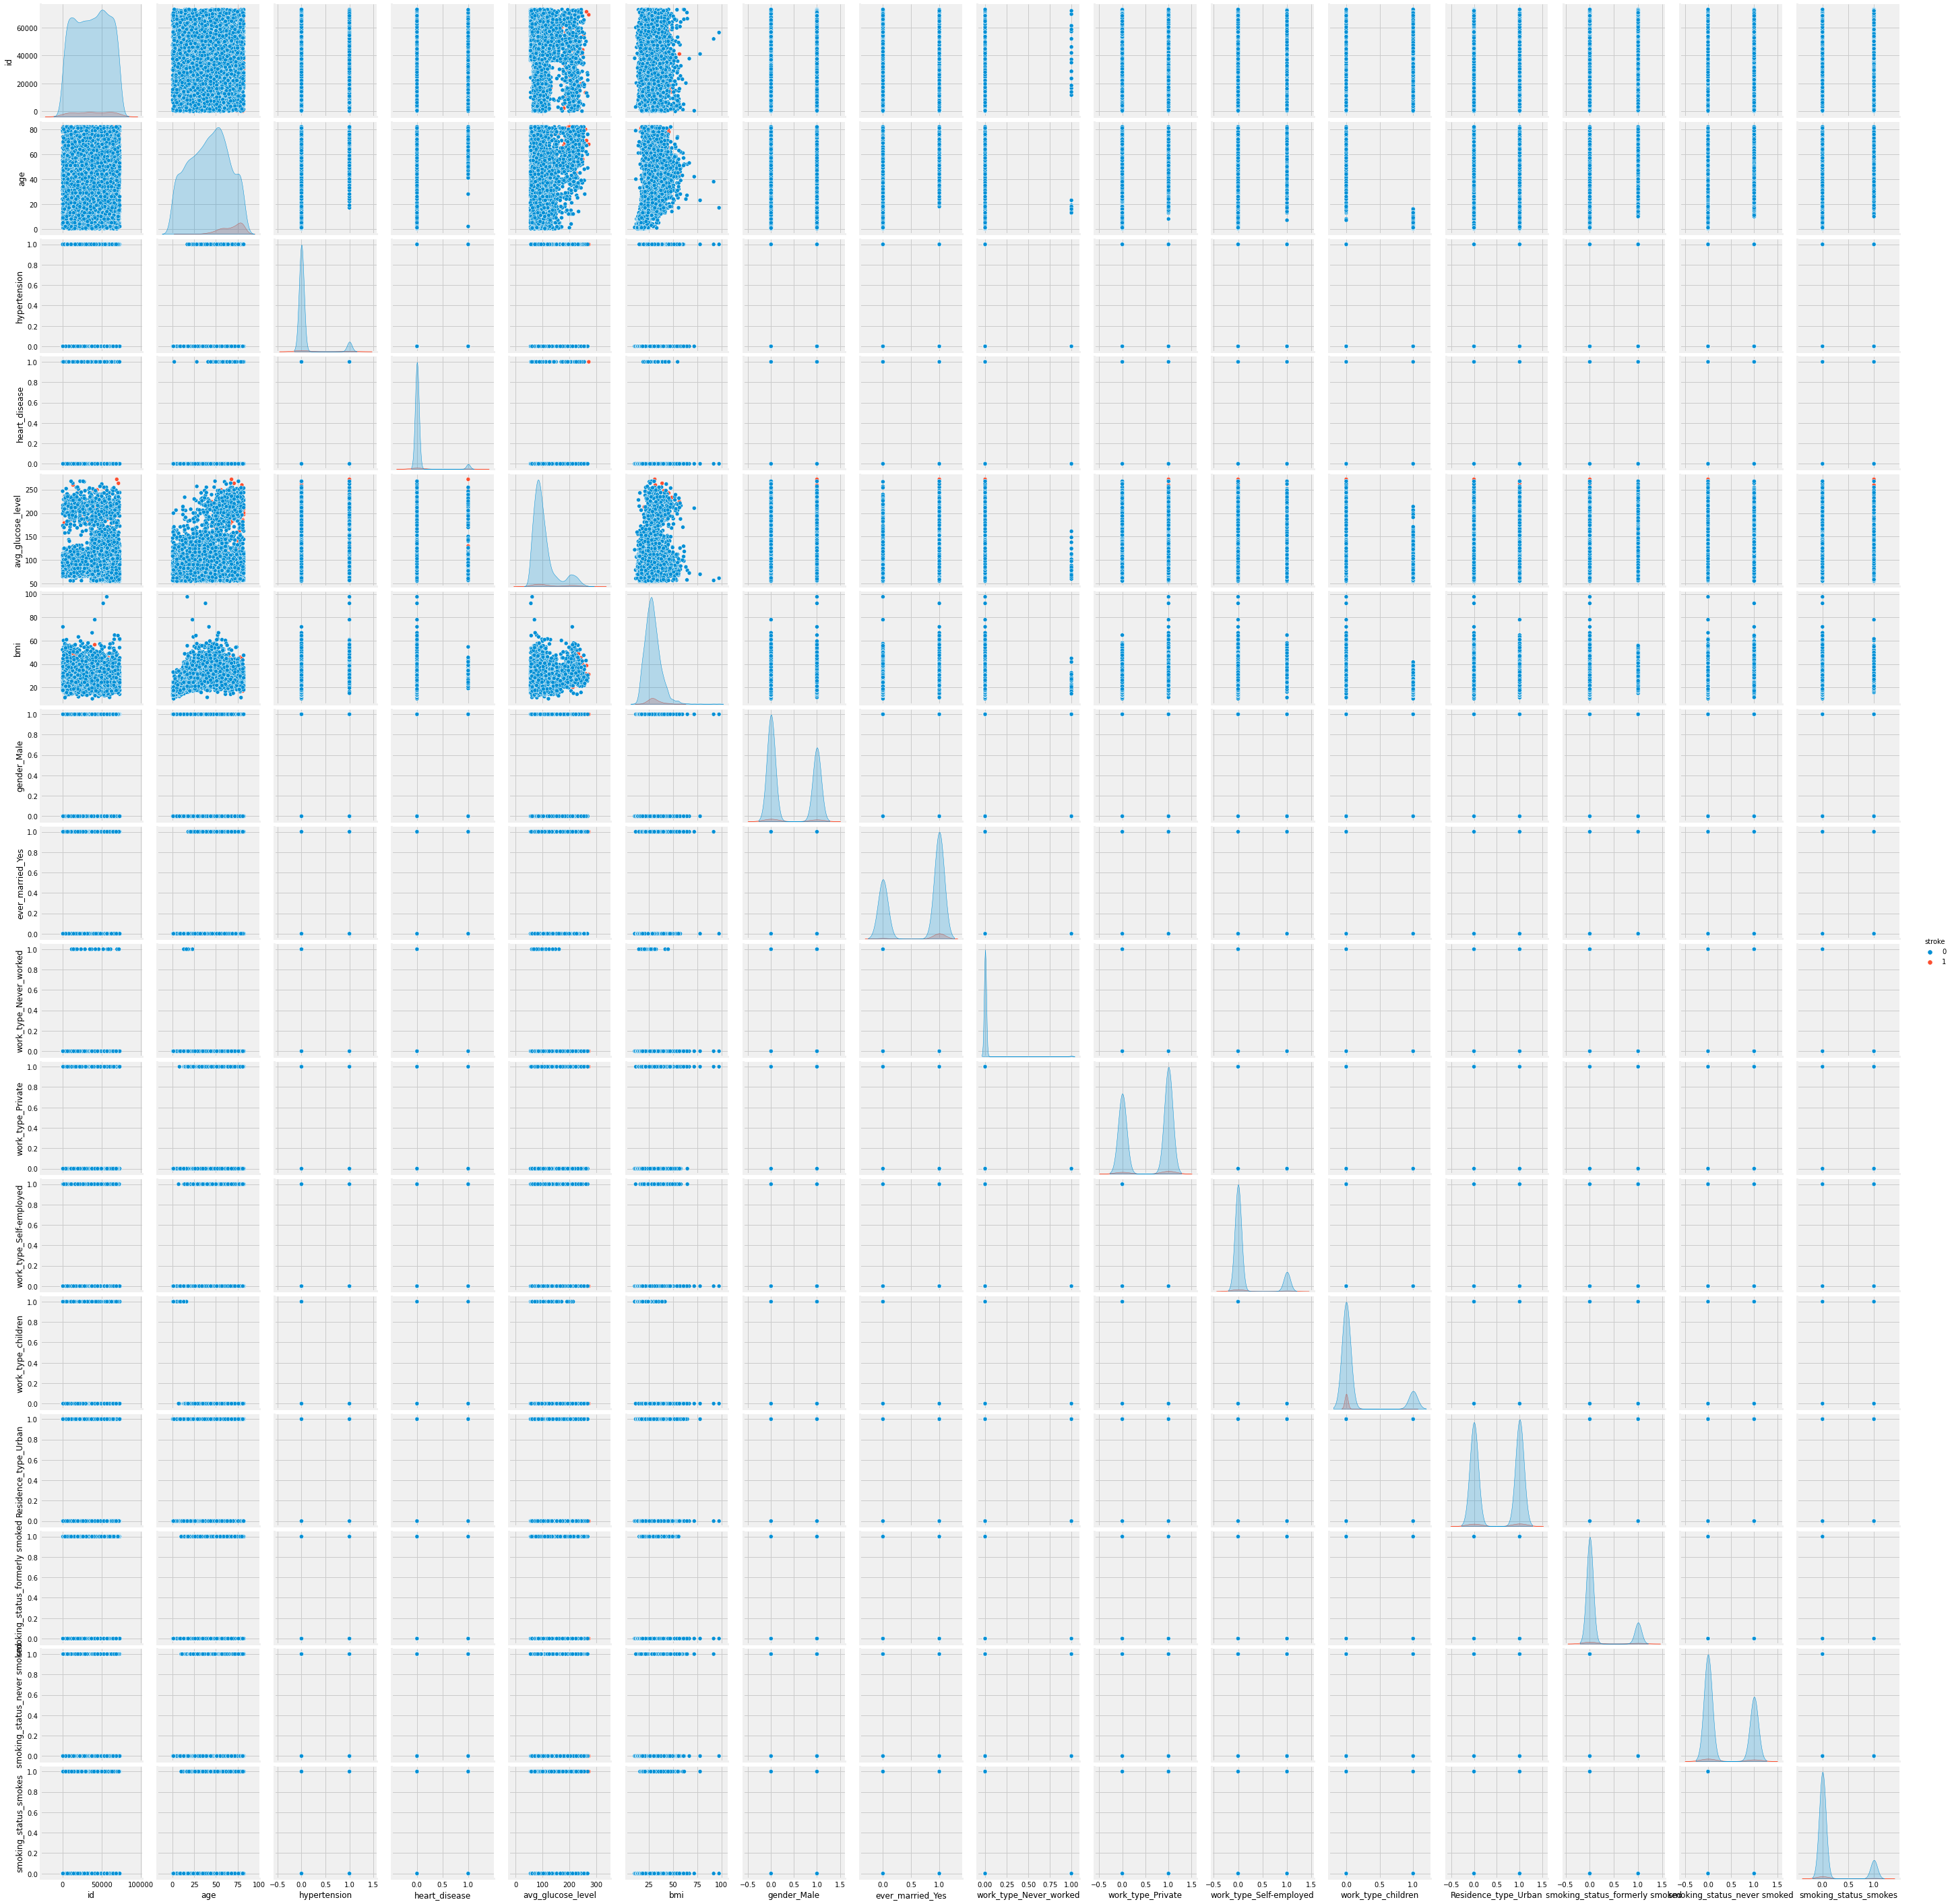

In [26]:
sns.pairplot(df, hue='stroke');

In [27]:
df.work_type_children.value_counts()

0    4237
1     671
Name: work_type_children, dtype: int64

In [28]:
df[df.stroke==1]

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,0,1,228.69,36.6,1,1,1,0,1,0,0,1,1,0,0
1,31112,80.0,0,1,105.92,32.5,1,1,1,0,1,0,0,0,0,1,0
2,60182,49.0,0,0,171.23,34.4,1,0,1,0,1,0,0,1,0,0,1
3,1665,79.0,1,0,174.12,24.0,1,0,1,0,0,1,0,0,0,1,0
4,56669,81.0,0,0,186.21,29.0,1,1,1,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,40460,68.0,1,1,247.51,40.5,1,0,1,0,1,0,0,1,1,0,0
205,17739,57.0,0,0,84.96,36.7,1,1,1,0,1,0,0,0,0,0,0
206,49669,14.0,0,0,57.93,30.9,1,0,0,0,0,0,1,0,0,0,0
207,27153,75.0,0,0,78.80,29.3,1,0,1,0,0,1,0,0,1,0,0


In [29]:
df[df.stroke==1]['age'].describe()

count    209.000000
mean      67.712919
std       12.402848
min       14.000000
25%       58.000000
50%       70.000000
75%       78.000000
max       82.000000
Name: age, dtype: float64

In [30]:
df[df.stroke==1]['age'].value_counts()

78.0    16
80.0    16
81.0    14
79.0    13
57.0    10
68.0     9
82.0     9
63.0     7
77.0     7
74.0     7
70.0     6
59.0     6
69.0     6
54.0     6
71.0     5
72.0     5
76.0     5
60.0     4
61.0     4
73.0     4
58.0     4
66.0     3
49.0     3
56.0     3
67.0     3
45.0     3
75.0     3
51.0     3
50.0     3
39.0     3
53.0     2
65.0     2
55.0     2
64.0     2
48.0     2
52.0     2
38.0     1
46.0     1
47.0     1
32.0     1
43.0     1
14.0     1
42.0     1
Name: age, dtype: int64

/Users/bsameera/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='stroke', ylabel='count'>

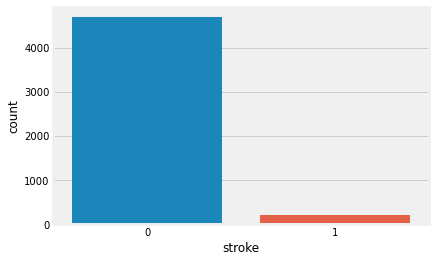

In [32]:
sns.countplot('stroke', data=df)

In [37]:
df.groupby(['stroke'])['age'].mean()

stroke
0    41.763805
1    67.712919
Name: age, dtype: float64

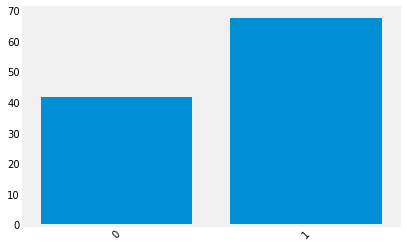

In [58]:
PropType = df.groupby(['stroke'])['age'].mean()
plt.bar(range(len(PropType)),PropType.values)
plt.xticks(range(len(PropType)),PropType.index,rotation = 45)
plt.grid();

In [59]:
# plt.bar([df.hypertension.sum(), df.heart_disease.sum(), df.avg_glucose_level.sum()], df.age)

In [60]:
X = df.drop(columns=['stroke'], axis=1)
y = df.stroke

print(len(X.columns))
print(X.columns)

16
Index(['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'gender_Male', 'ever_married_Yes', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children',
       'Residence_type_Urban', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes'],
      dtype='object')


In [61]:
y.shape

(4908,)

## Logistic Regression

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

lm1 = LogisticRegression(C=1000) # setting C very high essentially removes regularization
lm1.fit(X_train, y_train)

LogisticRegression(C=1000)

In [63]:
train_score = lm1.score(X_train, y_train)
test_score = lm1.score(X_test, y_test)

print("The score for logistic regression is ")
print("Train set: {:6.2f}%".format(100*train_score))
print("Test set: {:6.2f}%".format(100*test_score))

The score for logistic regression is 
Train set:  95.90%
Test set:  94.70%


In [64]:
y_pred = lm1.predict(X_test)

print("Logistic Regression - ")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1: {f1_score(y_test, y_pred)}")

Logistic Regression - 
Precision: 1.0
Recall: 0.018867924528301886
F1: 0.037037037037037035


In [65]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    stroke_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(stroke_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['no_stroke', 'stroke'],
           yticklabels=['no_stroke', 'stroke']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [66]:
# a = [[3,4],[5,6],[8,9]]
# a[:,1]
# TypeError: list indices must be integers or slices, not tuple


In [67]:
lm1.predict_proba(X_test)

array([[0.9898464 , 0.0101536 ],
       [0.97560283, 0.02439717],
       [0.97704963, 0.02295037],
       ...,
       [0.99232992, 0.00767008],
       [0.97256514, 0.02743486],
       [0.96434327, 0.03565673]])

In [68]:
lm1.predict_proba(X_test)[:,1]

array([1.01535951e-02, 2.43971715e-02, 2.29503668e-02, 1.38982815e-02,
       1.17771463e-01, 2.45357163e-02, 4.36595035e-02, 6.04331578e-02,
       1.00305948e-01, 3.29994413e-02, 1.55950727e-02, 1.36734055e-01,
       2.76389176e-02, 1.36208880e-01, 4.03171196e-02, 1.63007838e-02,
       2.47432067e-01, 2.06030229e-03, 1.12962658e-02, 7.40049740e-02,
       6.35265940e-02, 7.63712523e-02, 1.27173532e-02, 1.90902958e-03,
       1.99327143e-01, 9.95308149e-03, 5.65890842e-03, 3.98744296e-02,
       2.97174082e-03, 3.37679282e-02, 5.83972022e-02, 1.95416991e-02,
       3.91204450e-02, 5.24229646e-04, 5.16874196e-02, 1.57288728e-02,
       8.43047549e-02, 7.72646028e-02, 7.27373427e-02, 3.87206634e-03,
       3.30255291e-02, 1.87834601e-02, 9.42601282e-03, 2.39321554e-04,
       2.54237785e-02, 8.66493016e-03, 3.54135050e-02, 4.50201617e-03,
       1.04014084e-03, 8.76850322e-04, 9.09007526e-02, 9.76509511e-02,
       1.41109777e-01, 1.14875314e-01, 2.02911895e-03, 3.72855344e-02,
      

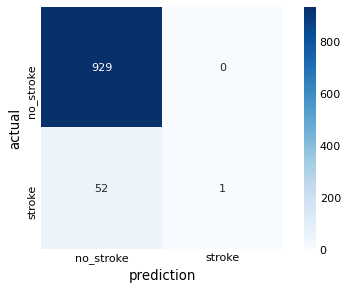

In [69]:
make_confusion_matrix(lm1)

In [70]:
# Let's see how our confusion matrix changes with changes to the cutoff! 

from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(lm1, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

### TN       FP
### FN       TP

### precision = TP/(TP+FP)
### Recall = TP/(TP+FN)
### Specificity = TN/(TN+FP)
### Sensitivity = Recall

In [71]:
# threshold - 0.04

precision = 31/(31+334) 
precision

0.08493150684931507

In [72]:
Recall = 31/(31+22)
Recall

0.5849056603773585

In [73]:
# specificity = (929/(929+0)) = 1/1

# after threshold adjustment
specificity = 595/(595+334)
specificity

0.6404736275565124

In [74]:
lm1 = LogisticRegression(C=1000) # setting C very high essentially removes regularization
lm1.fit(X_train, y_train)

train_score = lm1.score(X_train, y_train)
test_score = lm1.score(X_test, y_test)

print("The score for logistic regression is ")
print("Train set: {:6.2f}%".format(100*train_score))
print("Test set: {:6.2f}%".format(100*test_score))

print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1: {f1_score(y_test, y_pred)}")

The score for logistic regression is 
Train set:  95.90%
Test set:  94.70%
Precision: 1.0
Recall: 0.018867924528301886
F1: 0.037037037037037035


## KNN Classifier

In [75]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(f"Accuracy Score : {accuracy_score(y_test, y_pred)}")
print(f"F1: {f1_score(y_test, y_pred)}")
print('f1-macro', f1_score(y_test, y_pred, average='macro'))
print('f1-micro', f1_score(y_test, y_pred, average='micro'))
print('f1-weighted', f1_score(y_test, y_pred, average='weighted'))
print('f1', f1_score(y_test, y_pred, average=None))
print(f"Log_loss: {log_loss(y_test, y_pred)}")
print(f"ROC AUC: {roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])}")

Accuracy Score : 0.9470468431771895
F1: 0.037037037037037035
f1-macro 0.5049059530734923
f1-micro 0.9470468431771895
f1-weighted 0.9222717070937925
f1 [0.97277487 0.03703704]
Log_loss: 1.8289372429076947
ROC AUC: 0.5389138249690273


## Random Forest with Cross-Fold Validation

In [76]:

rfc = RandomForestClassifier(n_jobs=-1 ,n_estimators=200, oob_score = True) 

param_grid = { 
    'n_estimators': [100, 200],
    'max_depth': [2,4,8],
    'max_features': ['auto', 'sqrt', 'log2']   
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='neg_log_loss')
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)

{'max_depth': 4, 'max_features': 'auto', 'n_estimators': 200}


In [77]:
CV_rfc.best_score_

-0.13915436232841844

In [78]:
y_pred_rfc = CV_rfc.predict(X_test)

In [79]:
print("Random Forest Classifier with CV -")
print(f"Precision: {precision_score(y_test, y_pred_rfc)}")
print(f"Recall: {recall_score(y_test, y_pred_rfc)}")
print(f"F1: {f1_score(y_test, y_pred_rfc)}")

Random Forest Classifier with CV -
Precision: 0.0
Recall: 0.0
F1: 0.0


/Users/bsameera/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [80]:
rfc = RandomForestClassifier(n_jobs=-1 ,n_estimators=200, oob_score = True) 

param_grid = { 
    'n_estimators': [100, 200],
    'max_depth': [4,8,16],
    'max_features': ['auto', 'sqrt', 'log2']   
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3, scoring='neg_log_loss')
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)

{'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 200}


In [81]:
CV_rfc.best_score_

-0.13790013943706875

In [82]:
y_pred_rfc = CV_rfc.predict(X_test)

print("Random Forest Classifier with CV -")
print(f"Precision: {precision_score(y_test, y_pred_rfc)}")
print(f"Recall: {recall_score(y_test, y_pred_rfc)}")
print(f"F1: {f1_score(y_test, y_pred_rfc)}")

Random Forest Classifier with CV -
Precision: 0.0
Recall: 0.0
F1: 0.0


/Users/bsameera/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
# https://stats.stackexchange.com/questions/8025/what-are-correct-values-for-precision-and-recall-when-the-
# denominators-equal-0


## XGBoost

In [84]:
gbm = xgb.XGBRegressor( 
                       n_estimators=30000, #arbitrary large number
                       max_depth=3,
                       objective="reg:squarederror",  # Other options: https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )

eval_set=[(X_train,y_train),(X_test,y_test)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error',
                    early_stopping_rounds=20,
                    verbose=True #gives output log as below
                   )

[0]	validation_0-error:0.03973	validation_1-error:0.05397
[1]	validation_0-error:0.03923	validation_1-error:0.05499
[2]	validation_0-error:0.03923	validation_1-error:0.05397
[3]	validation_0-error:0.03948	validation_1-error:0.05397
[4]	validation_0-error:0.03948	validation_1-error:0.05397
[5]	validation_0-error:0.03897	validation_1-error:0.05499
[6]	validation_0-error:0.03948	validation_1-error:0.05397
[7]	validation_0-error:0.03897	validation_1-error:0.05499
[8]	validation_0-error:0.03897	validation_1-error:0.05499
[9]	validation_0-error:0.03897	validation_1-error:0.05397
[10]	validation_0-error:0.03923	validation_1-error:0.05397
[11]	validation_0-error:0.03923	validation_1-error:0.05397
[12]	validation_0-error:0.03923	validation_1-error:0.05397
[13]	validation_0-error:0.03923	validation_1-error:0.05397
[14]	validation_0-error:0.03897	validation_1-error:0.05397
[15]	validation_0-error:0.03923	validation_1-error:0.05397
[16]	validation_0-error:0.03923	validation_1-error:0.05397
[17]	va

In [85]:
# predict using n_estimators with lowest validation error

from sklearn.metrics import mean_squared_error as rmse
rmse(gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit),y_test) 

0.21053893022870052

## Oversampling

In [86]:
import imblearn.over_sampling

n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)

# create 4x as many positive samples
ratio = {1 : n_pos * 4, 0 : n_neg}

# randomly oversample positives
ROS =imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio,random_state=42)
X_tr_rs, y_tr_rs = ROS.fit_resample(X_train, y_train)


In [87]:
lm2 = LogisticRegression(C=1000) # setting C very high essentially removes regularization
lm2.fit(X_tr_rs, y_tr_rs)

LogisticRegression(C=1000)

In [88]:
train_score = lm2.score(X_tr_rs, y_tr_rs)
test_score = lm2.score(X_test, y_test)

print("The score for logistic regression is ")
print("Train set: {:6.2f}%".format(100*train_score))
print("Test set: {:6.2f}%".format(100*test_score))

y_pred2 = lm2.predict(X_test)

print("\nLogistic Regression - ")
print(f"Precision: {precision_score(y_test, y_pred2)}")
print(f"Recall: {recall_score(y_test, y_pred2)}")
print(f"F1: {f1_score(y_test, y_pred2)}")

The score for logistic regression is 
Train set:  85.87%
Test set:  92.67%

Logistic Regression - 
Precision: 0.2564102564102564
Recall: 0.18867924528301888
F1: 0.21739130434782608


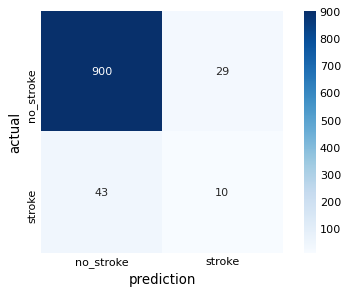

In [89]:
make_confusion_matrix(lm2)

In [90]:
interactive(lambda threshold: make_confusion_matrix(lm2, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [91]:
# threshold 0.08
precision = 44/(44+549)
print('precision : ', precision)

recall = 44/(44+9)
print('recall : ', recall)

precision :  0.07419898819561552
recall :  0.8301886792452831


In [92]:
# threshold 0.06
precision = 49/(49+643)
print('precision : ', precision)

recall = 49/(49+4)
print('recall : ', recall)

precision :  0.0708092485549133
recall :  0.9245283018867925


In [93]:
# threshold 0.16

print("Logistic Regression \nThreshold - 0.16")
precision = 34/(34+270)
print('precision : ', precision)

recall = 34/(34+19)
print('recall : ', recall)

Logistic Regression 
Threshold - 0.16
precision :  0.1118421052631579
recall :  0.6415094339622641


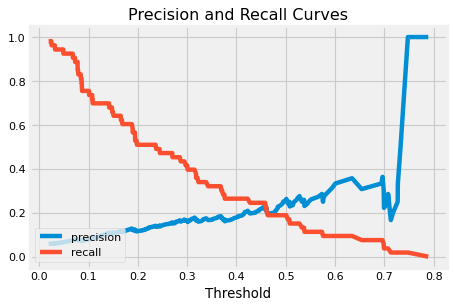

In [94]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lm2.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves');

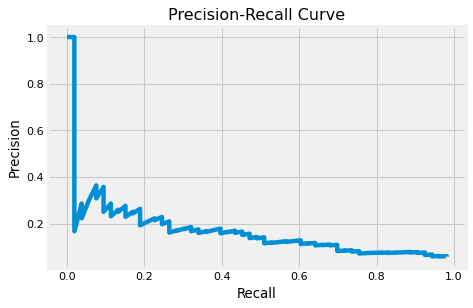

In [95]:
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

In [96]:
fpr, tpr, thresholds = roc_curve(y_test, lm2.predict_proba(X_test)[:,1])

ROC AUC score =  0.7244754960700286


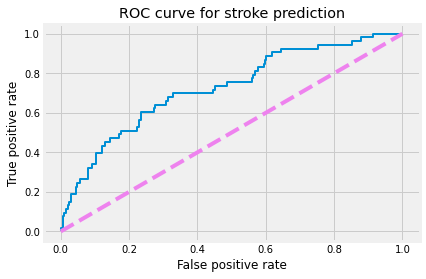

In [97]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for stroke prediction');
print("ROC AUC score = ", roc_auc_score(y_test, lm2.predict_proba(X_test)[:,1]))

## Random Forest Classifier with CV

In [98]:
rfc = RandomForestClassifier(n_jobs=-1 ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [100, 200],
    'max_depth': [2,4,8],
    'max_features': ['auto', 'sqrt', 'log2']   
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='neg_log_loss')
CV_rfc.fit(X_tr_rs, y_tr_rs)
print(CV_rfc.best_params_)

{'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 200}


In [99]:
CV_rfc.best_score_

-0.19517858962146614

In [100]:
y_pred_rfc = CV_rfc.predict(X_test)

print("Random Forest Classifier with CV -")
print(f"Precision: {precision_score(y_test, y_pred_rfc)}")
print(f"Recall: {recall_score(y_test, y_pred_rfc)}")
print(f"F1: {f1_score(y_test, y_pred_rfc)}")

Random Forest Classifier with CV -
Precision: 0.08333333333333333
Recall: 0.018867924528301886
F1: 0.03076923076923077


## XGBoost

In [101]:
gbm = xgb.XGBRegressor( 
                       n_estimators=30000, #arbitrary large number
                       max_depth=3,
                       objective="binary:logistic",  # Other options: https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )

eval_set=[(X_tr_rs,y_tr_rs),(X_test,y_test)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    X_tr_rs, y_tr_rs, 
                    eval_set=eval_set,
                    eval_metric='error',
                    early_stopping_rounds=20,
                    verbose=True #gives output log as below
                   )

# objective="binary:logistic"
# eval_metric='error', 
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html
# compare the models with logloss


[0]	validation_0-error:0.12472	validation_1-error:0.07434
[1]	validation_0-error:0.12745	validation_1-error:0.05906
[2]	validation_0-error:0.11629	validation_1-error:0.06925
[3]	validation_0-error:0.12449	validation_1-error:0.06212
[4]	validation_0-error:0.11629	validation_1-error:0.07026
[5]	validation_0-error:0.12608	validation_1-error:0.06314
[6]	validation_0-error:0.12517	validation_1-error:0.06110
[7]	validation_0-error:0.12631	validation_1-error:0.06314
[8]	validation_0-error:0.11629	validation_1-error:0.06823
[9]	validation_0-error:0.11561	validation_1-error:0.06823
[10]	validation_0-error:0.11652	validation_1-error:0.06619
[11]	validation_0-error:0.11561	validation_1-error:0.06823
[12]	validation_0-error:0.11539	validation_1-error:0.06823
[13]	validation_0-error:0.11743	validation_1-error:0.06823
[14]	validation_0-error:0.11925	validation_1-error:0.06721
[15]	validation_0-error:0.11675	validation_1-error:0.06823
[16]	validation_0-error:0.11539	validation_1-error:0.06925
[17]	va

In [102]:
# rmse(gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit),y_test) 

In [103]:
# y_pred_XGB = fit_model.predict(X_test)

# print("XGBoost -")
# print(f"Precision: {precision_score(y_test, y_pred_XGB)}")
# print(f"Recall: {recall_score(y_test, y_pred_XGB)}")
# print(f"F1: {f1_score(y_test, y_pred_XGB)}")

# error

In [104]:
# make_confusion_matrix(fit_model)

# AttributeError: 'XGBRegressor' object has no attribute 'predict_proba'

## Ensemble